### Linear and DNN regression for Inter-vehicle Distance Prediction
Tutorial from : https://www.tensorflow.org/tutorials/keras/regression

https://colab.research.google.com/github/frogermcs/TFLite-Tester/blob/master/notebooks/Testing_TFLite_model.ipynb

##### Upload csv file from local to colab

In [ ]:
from google.colab import files
import io
import pandas as pd

uploaded = files.upload()
# import file into a dataframe 
dataset_raw = pd.read_csv(io.BytesIO(uploaded['cacc_experiment2.csv']))

Saving cacc_experiment2.csv to cacc_experiment2 (1).csv


Clean Data before moving forward

In [ ]:
dataset = dataset_raw.copy()
# Select data for node 2 and remove -ve distanceFromLead 
dataset = dataset[(dataset['NodeID'] == 2) & (dataset['InterVehicleDistance'] >= 0)]
# Drop unused columns
dataset.drop(["Time","NodeID"], axis=1, inplace=True)
# Drop rows with unknown values
dataset = dataset.dropna()

Begin ML activities from Here

In [ ]:
# Use seaborn for pairplot
!pip install -q seaborn

In [ ]:
# Import neccesary libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

print(tf.__version__)

2.5.0


Split Data into train and test

In [ ]:
train_dataset = dataset.sample(frac=0.85, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
# dataset.shape
# train_dataset.info()
# train_dataset.describe().transpose()
# train_dataset.describe().transpose()[['mean', 'std']]

Split features from label

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('InterVehicleDistance')
test_labels = test_features.pop('InterVehicleDistance')

print(train_features.shape)
print(test_features.shape)

(1019, 6)
(180, 6)


Normalization Layer

In [ ]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
# print(normalizer.mean.numpy())

In [ ]:
# Code for plotting loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 20])
  plt.xlabel('Epoch')
  plt.ylabel('Error [InterVehicleDistance]')
  plt.legend()
  plt.grid(True)

#### Linear Regression

In [ ]:
# linear_model = tf.keras.Sequential([
#     normalizer,
#     layers.Dense(units=1)
# ])

# linear_model.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.1),
#     loss='mean_absolute_error')

# # Train the models
# history = linear_model.fit(
#     train_features, train_labels, 
#     epochs=100,
#     # suppress logging
#     verbose=0,
#     # Calculate validation results on 20% of the training data
#     validation_split = 0.2)

In [ ]:
# plot_loss(history)

Collect test results for later evaluation

In [ ]:
# test_results = {}
# test_results['linear_model'] = linear_model.evaluate(
#     test_features,
#     test_labels, verbose=0)

### Deep Neural Network

In [ ]:
# Takes in normalized training data

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [ ]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

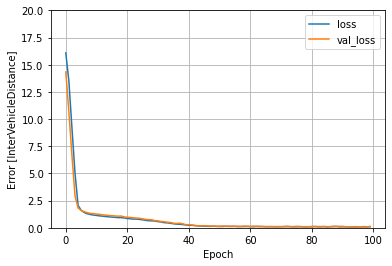

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
# PRedict some results
prediction = dnn_model.predict(test_features[:5]).flatten()
print(prediction)
print(test_labels[:5])
# print((test_features[:1]).info())

[ 8.732 11.797 11.957 12.263 13.233]
112     8.6803
232    11.4151
242    11.7268
252    12.0110
282    13.0004
Name: InterVehicleDistance, dtype: float64


### Performance Check

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [InterVehicleDistance]']).T

,Mean absolute error [InterVehicleDistance]
dnn_model,0.12856


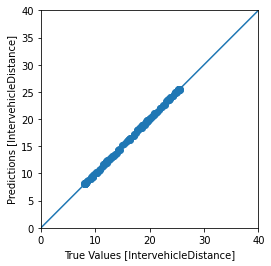

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [IntervehicleDistance]')
plt.ylabel('Predictions [IntervehicleDistance]')
lims = [0, 40]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Save the model

In [ ]:
export_dir = 'saved_model'
tf.saved_model.save(dnn_model, export_dir)
# dnn_model.save('dnn_model')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
%%bash -s $export_dir
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['normalization_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, -1)
      name: serving_default_normalization_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


Convert saved model to tflite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

Save the tflite model

In [ ]:
import pathlib

tflite_model_lite = pathlib.Path('cacc_model.tflite')
tflite_model_lite.write_bytes(tflite_model)


8880

Run model with TFlite runtime 

In [ ]:

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='cacc_model.tflite')
# interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Resize input and output tensors to handle input of 6 feature columns
interpreter.resize_tensor_input(input_details[0]['index'], (1, 6))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 1))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])


== Input details ==
name: serving_default_normalization_input:0
shape: [1 6]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 1]
type: <class 'numpy.float32'>


In [ ]:
# Point to data and run interpreter
interpreter.set_tensor(input_details[0]['index'], np.array(test_features[:1], dtype='f'))
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print(tflite_results)
print(test_labels[:1])

[[8.716]]
112    8.6803
Name: InterVehicleDistance, dtype: float64


In [ ]:
print(np.array(test_features[:1], dtype='f'))

[[181.957   1.296   0.818 190.637   1.679   0.411]]
